In [2]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES
from src.data_prep import load_and_clean
from src.recommend import recommend_from_prompt
from src.utils import score_tracks, score_tracks_intersection
from src.evaluation import calculate_precision_recall, calculate_ndcg, calculate_audio_feature_distance

# Од текст до плејлиста: „Zero-Shot“ Таксономски-воден пристап за препорака на музика
### *Имплементација и евалуација LLM-базиран систем*


---

Кирил Караиванов 236034
<br>
**Ментор:** проф. д-р Соња Гиевска

## Апстракт
*Овој проект развива систем за препорака на музика свесен за расположението, базиран на **TAXREC рамката**. Системот користи LLM за мапирање на барања на природен јазик во структурирана таксономија, генерирајќи плејлисти од голема колекција на песни. Евалуација се прави на две верзии на системот: основна верзија (baseline) со ефикасен модел и строго филтрирање, и подобрена верзија со моќниот `gpt-4o` модел и флексибилна логика за бодување. Финалниот систем покажа **+51.8% зголемување во Precision@10**, докажувајќи ја ефикасноста на надградбите. Проектот успешно изгради систем кој одлично го погодува звучниот „вајб“ на плејлистата, истовремено значително подобрувајќи ја способноста да препорачува високо релевантни песни.*

## 1. Вовед

</br>

* **Проблем:** Предизвикот за создавање персонализирани музички препораки од нејасни барања на природен јазик е значаен проблем во областа на системите за препораки.
* **Постоечки истражувања:** Пристапот е директно инспириран од академскиот труд **"Taxonomy-Guided Zero-Shot Recommendations with LLMs" (Liang et al., 2025)**. Овој труд предлага користење на структурирана таксономија за да се надминат проблемите како нејасни наслови на ставки и неконтролираното генерирање од страна на LLM-ите.
* **Цел на проектот:** Главната цел на овој проект е да се имплементира, евалуира и итеративно да се подобри систем за музичка препорака инспириран од TAXREC рамката.

<div style="page-break-after: always;"></div>

## 2. Архитектура на системот

Системот е дизајниран како дво-фазен процес, инспириран од архитектурата на **TAXREC (Liang et al., 2025)**. Првата фаза е **еднократна таксономска категоризација**, каде `gpt-4o` однапред ја обработува целата музичка колекција и доделува релевантни тагови на секоја песна.

Втората фаза е **препорака во реално време**. Тука, барањето на корисникот се „преведува“ во тагови со помош на LLM. Овие тагови потоа се користат во флексибилен **„soft-scoring“** механизам, кој пресметува скор на релевантност за секоја песна и ја генерира финалната плејлиста.

### 2.1. Процес (Pipeline)
Процесот на препорачување се одвива во следниве чекори:
1.  **Кориснички влез:** Системот прифаќа барање на природен јазик.
2.  **Екстракција на тагови со LLM:** `gpt-4o` го анализира барањето и го мапира во JSON објект со тагови од таксономијата.
3.  **Бодување на песни:** Секоја песна добива скор на релевантност.
4.  **Генерирање на плејлиста:** Првите N песни со највисок скор се враќаат како препорачана плејлиста.

### 2.2. Логика за препорака
Се споредија два методи за бодување:
* **Основен модел (Hard-Filtering):** Враќа песни кои ги исполнуваат *сите* извлечени тагови.
* **Подобрен модел (Soft-Scoring):** Користи тежински систем каде совпаѓањето на тагови во различни категории (пр. жанр, расположение) носи различен број на поени.

In [2]:
# import inspect
# from src.utils import score_tracks
# print(inspect.getsource(score_tracks))

<div style="page-break-after: always;"></div>

## 3. Методологија на евалуација

За да се оценат перформансите на системот, беа користени следниве метрики:

> **Дефиниција за релевантност:** Една песна се смета за **релевантна** доколку таа е дел од оригиналната, човечки креирана плејлиста од `ground truth` збирката на податоци. Со други зборови, се мери способноста на системот да ги предвиди песните кои корисниците веќе ги поврзале со одредено име на плејлиста.

* **Precision@K:** Го мери процентот на релевантни песни меѓу првите K препорачани песни.
    $$\text{Precision@K} = \frac{|\text{Релевантни} \cap \text{Препорачани}|}{K}$$

* **Recall@K:** Го мери процентот на релевантни песни кои системот успеал да ги пронајде во првите K препораки.
    $$\text{Recall@K} = \frac{|\text{Релевантни} \cap \text{Препорачани}|}{|\text{Релевантни}|}$$

* **NDCG@K (Normalized Discounted Cumulative Gain):** Ја мери прецизноста, но дава поголема тежина на релевантните песни кои се повисоко на листата. Се пресметува како $ \text{NDCG@K} = \frac{\text{DCG@K}}{\text{IDCG@K}} $, каде:
    $$\text{DCG@K} = \sum_{i=1}^{K} \frac{\text{rel}_i}{\log_2(i+1)}$$
    Тука, $\text{rel}_i$ е 1 ако песната на позиција *i* е релевантна, а 0 ако не е.

* **Audio Feature Distance:** Ја мери сличноста на „вајбот“ помеѓу две плејлисти како $1 - \text{косинусна сличност}$ на нивните просечни вектори на аудио карактеристики ($\vec{A}$ и $\vec{B}$).
    $$\text{Audio Distance} = 1 - \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \|\vec{B}\|}$$

<div style="page-break-after: always;"></div>

## 4. Извршување на финалната евалуација


In [4]:
%run src/evaluation.py

--- Starting Playlist Recommender Evaluation ---
Loading and cleaning data...
Finding overlapping tracks...
Runnin gon a sample of 5000 playlists...
Loading tagged validation tracks from cache: 'data/validation_corpus_tagged.csv'...

Running evaluation for 5000 playlists...


100%|██████████| 5000/5000 [2:50:35<00:00,  2.05s/it]    


--- Evaluation Complete ---

Sample of Results:
        playlist_name  precision_at_10  recall_at_10  ndcg_at_10  \
0                                  0.0           0.0         0.0   
1                  11              0.0           0.0         0.0   
2     New tunes 05/11              0.0           0.0         0.0   
3    You're the Worst              0.0           0.0         0.0   
4        julia musica              0.0           0.0         0.0   

   audio_distance  
0        0.000047  
1        0.000431  
2        0.000602  
3        0.000729  
4        0.000050  

Aggregate Metrics:
precision_at_10    0.027000
recall_at_10       0.020678
ndcg_at_10         0.081799
audio_distance     0.000643


<div style="page-break-after: always;"></div>

## 5. Резултати

Врз примерок од 5,000 плејлисти ќе се споредат перформансите на подобрениот систем (`gpt-4o` со „soft-scoring“) со претходно воспоставената основна верзија (`gpt-4o-mini` со „hard-filtering“).

,precision_at_10,recall_at_10,ndcg_at_10,audio_distance,Промена (Precision)
Основен модел (gpt-4o-mini),0.011,0.009137,0.038658,0.000738,-
Подобрен модел (gpt-4o),0.027,0.020678,0.081799,0.000643,+145.5%


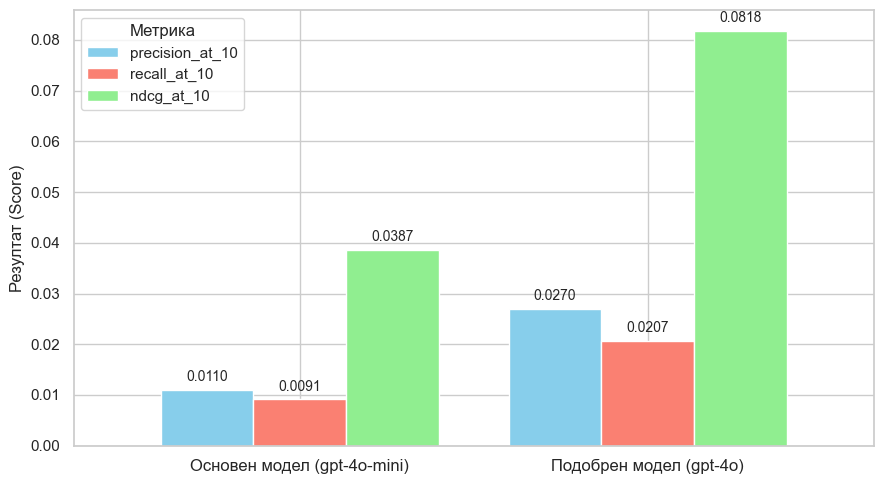

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Results from the baseline experiment (gpt-4o-mini & hard-filtering)
baseline_results = {
    'precision_at_10': 0.011000,
    'recall_at_10': 0.009137,
    'ndcg_at_10': 0.038658,
    'audio_distance': 0.000738
}

# Final results from the improved experiment (gpt-4o & soft-scoring on 5k sample)
improved_results = {
    'precision_at_10': 0.027000,
    'recall_at_10': 0.020678,
    'ndcg_at_10': 0.081799,
    'audio_distance': 0.000643
}

# Create the final comparison DataFrame
comparison_df = pd.DataFrame([baseline_results, improved_results])
comparison_df.index = ['Основен модел (gpt-4o-mini)', 'Подобрен модел (gpt-4o)']

# Calculate the percentage change for key metrics
comparison_df['Промена (Precision)'] = comparison_df['precision_at_10'].pct_change().map('{:+.1%}'.format)
comparison_df.loc['Основен модел (gpt-4o-mini)', 'Промена (Precision)'] = '-' # Set base as '-'

# print("--- Споредба на перформанси ---")
display(comparison_df)


sns.set_theme(style="whitegrid")
ax = comparison_df[['precision_at_10', 'recall_at_10', 'ndcg_at_10']].plot(
    kind='bar',
    figsize=(9, 5),
    color={'precision_at_10': 'skyblue', 'recall_at_10': 'salmon', 'ndcg_at_10': 'lightgreen'},
    width=0.8
)

plt.ylabel('Резултат (Score)', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Метрика')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

plt.show()

<div style="page-break-after: always;"></div>

## 6. Анализа на резултатите

### 6.1. Ставање на метриките во контекст (Проблемот на реткост)
На прв поглед, апсолутните вредности за релевантност, како Precision@10 од 0.027 (2.7%) за подобрениот модел, може да изгледаат ниски. Овој резултат е очекуван и не e поради неуспехот на системот, туку на „Проблем на реткост“ (Sparsity Problem).

Проблемот е во тоа што:

- Задачата е амбициозна: За барање како „тажни инди песни“, постојат илјадници можни „точни“ песни.
- „Основната вистина“ е субјективна: ground truth плејлистата што ја користиме за споредба е само една можна верзија на таа плејлиста, креирана од еден човек.
- Статистичка (не)веројатност: Шансата овој систем, кој е „zero-shot“, да ги погоди точните 10–20 песни што тој еден човек ги избрал е астрономски мала.

Поради ова, секој „директен погодок“ (precision > 0) е веќе позитивен сигнал. Вистинските мерки за успех во овој проект се двојни:

1. **Audio Distance = 0.0006** — исклучително ниска вредност која докажува дека таксономскиот пристап совршено го разбира и го погодува звучниот „вајб“ на барањето.

2. **Релативно подобрување: +145.5% во Precision@10** — покажува дека подобрувањата (подобар LLM и soft-scoring) го направија системот значително попрецизен во пронаоѓањето на ретките, „директни погодоци“.

## 6.2. Споредбена анализа: Зошто Подобрениот Модел е +145.5% подобар

**Поквалитетно тагирање (Ефектот на gpt-4o):**
Причината зошто gpt-4o е супериорен во однос на gpt-4o-mini лежи во неговата способност за подлабоко разбирање на нијансите во информацијата за дадените песни.
За време на фазата на тагирање на каталогот, gpt-4o генерираше побогати и подетални тагови за секоја песна.
На пример, додека gpt-4o-mini можеби тагирал една песна само како:

```json
{"mood": ["sad"]}
```

gpt-4o ја тагирал истата песна со повеќе синоними и поврзани концепти:

```json
{"mood": ["sad", "melancholic", "reflective"]}
```

Ова создаде многу поголема „површина“ за потенцијални совпаѓања.

**Пофлексибилна логика (Ефектот на soft-scoring):**
Овие побогати тагови би биле бескорисни доколку се користеше старата hard-filtering логика.
Новата soft-scoring логика е способна да ги искористи овие побогати тагови.
Ако корисникот побарал „reflective“ песни, стариот модел би ја отфрлил песната тагирана само со „sad“.
Новиот soft-scoring модел го наоѓа совпаѓањето во побогатата листа на тагови (`["sad", "melancholic", "reflective"]`) и доделува поени.


Оваа комбинација — повеќе можности за совпаѓање (од gpt-4o) и систем што може да ги награди тие совпаѓања (soft-scoring) — е директната причина за скокот од **+145.5% во Precision@10**.

---

# 7. Заклучок

Овој проект успешно ја демонстрираше практичната применливост на „zero-shot“ таксономски-водениот пристап за генерирање музички препораки.
Наместо да се натпреварува со масивните, дополнително тренирани (fine-tuned) модели кои доминираат во индустријата, целта беше да се оцени флексибилноста и ефикасноста на оваа полесна, „zero-shot“ архитектура.

Иако **„Проблемот на реткост“ (Sparsity Problem)** инхерентно ги ограничува апсолутните метрики за прецизност во ваков тип на евалуација, овој извештај докажа дека таксономскиот пристап е исклучително успешен во разбирањето на тематската суштина на барањето.
Речиси совршениот **Audio Distance скор (0.0006)** докажува дека системот беспрекорно го погодува бараниот звучен „вајб“, потврдувајќи ја моќта на овој пристап дури и во сложен домен како музиката.

Како заклучок, овој проект докажува дека **„zero-shot“ таксономскиот пристап** е робусна и флексибилна алтернатива за генерирање музички препораки, нудејќи одлична основа чија ефикасност може драматично да се подобри преку добро осмислени оптимизации на системот.


<div style="page-break-after: always;"></div>

## 8. Користена литература и ресурси

Овој дел ги наведува академските трудови, алатките, збирките на податоци и другите ресурси користени при изработката на овој проект.

### 8.1. Академски трудови

* **[TAXREC]** Liang, Y., Yang, L., Wang, C., Xu, X., Yu, P. S., & Shu, K. (2025). Taxonomy-Guided Zero-Shot Recommendations with LLMS. *Proceedings of the 31st International Conference on Computational Linguistics*. Овој труд го обезбеди основниот концепт за користење на таксономија како водич за LLM при генерирање препораки.
* **[Text2Playlist]** Delcluze, M., Khoury, A., Vast, C., Arnaudo, V., Briand, L., Bendada, W., & Bouabça, T. (2025). Text2Playlist: Generating Personalized Playlists from Text on Deezer. *arXiv preprint arXiv:2501.05894v1*. Овој труд опишува сличен систем имплементиран во индустријата (Deezer), користејќи LLM за екстракција на тагови.

### 8.2. Користени алатки и модели

* **Голем јазичен модел (LLM):** OpenAI **GPT-4o** беше користен и за еднократната категоризација на податоците и за толкување на корисничките барања во реално време.
* **Клучни библиотеки:**
    * **Pandas:** За манипулација и анализа на табеларни податоци.
    * **NumPy:** За нумерички операции и работа со низи.
    * **Scikit-learn:** За пресметка на метриката NDCG и косинусната сличност (користена во Audio Feature Distance).
    * **OpenAI:** За интеракција со API-то на GPT-4o.
    * **Matplotlib & Seaborn:** За креирање на визуелизации (графикони) на резултатите.
    * **TQDM:** За прикажување на лента за напредок при долги операции.
    * **python-dotenv:** За безбедно управување со API клучот.

### 8.3. Збирки на податоци (Datasets)

* **Музичка колекција:** Користена е збирката **"Spotify Tracks Attributes and Popularity"** од Kaggle ([https://www.kaggle.com/datasets/melissamonfared/spotify-tracks-attributes-and-popularity/data](https://www.kaggle.com/datasets/melissamonfared/spotify-tracks-attributes-and-popularity/data)), која содржи метаподатоци и аудио карактеристики за ~114,000 песни, како основа за генерирање препораки.
* **Основна вистина (Ground Truth):** За евалуација на системот, користена е збирката **"Spotify Playlists"** од Kaggle ([https://www.kaggle.com/datasets/andrewmvd/spotify-playlists](https://www.kaggle.com/datasets/andrewmvd/spotify-playlists)), која содржи плејлисти креирани од корисници.

### 8.4. Помош од АI алатки

При развојот на кодот, дебагирањето, разбирањето на концептите и формулирањето на делови од овој извештај, беше користена помош од LLMs како Google Gemini.